In [2]:
import pandas as pd
import statsmodels.api as sm
from scipy import interpolate
from pandas import Series, DataFrame, Panel
from string import ascii_lowercase as letters
from scipy.stats import chisqprob
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(1234)

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
    return(x,y)   
    
n=10000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data = rw2(n)
x=data[0]
y=data[1]
t=range(0,n)

In [4]:
# average distance
def rw2_distance(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    distance=[0]*n
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        distance[i]=(x[i]**2+y[i]**2)**0.5
    return distance 
    
n=10000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
data_distance = rw2_distance(n)
t=range(0,n)
#data_distance

In [5]:
number_of_simulations=100# this is the number of rows or row vectors
n=10000# number of columns or number of elements in that row vector
average_distances=np.zeros((number_of_simulations,n))
for i in range(number_of_simulations):
    average_distances[i]=rw2_distance(n)
#ask here if it's correct: average distance or just distance

In [6]:
rw2_distance(10)


[0, 2.0059, 2.8238, 4.4322, 5.8305, 4.8632, 4.3669, 4.6982, 5.5166, 5.7823]

In [29]:
matrix=np.zeros((2,5))# 2 rows 5 columns
matrix[1]=range(0,5)
matrix[0]=range(5,10)
print(matrix)
print(matrix.mean(axis=0))

[[ 5.  6.  7.  8.  9.]
 [ 0.  1.  2.  3.  4.]]
[ 2.5  3.5  4.5  5.5  6.5]


In [ ]:
# the mean average distance after 1 step, 2 steps, etc...

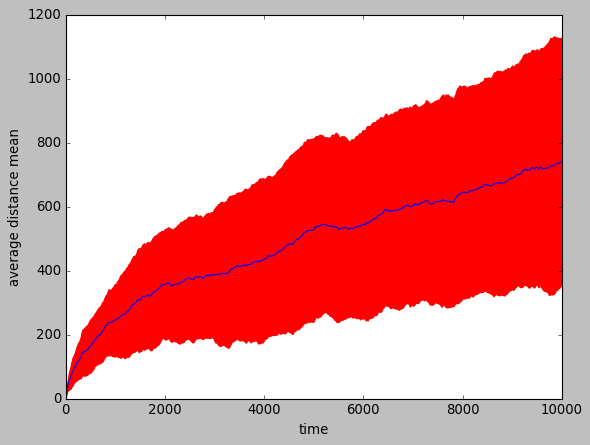

In [15]:
y=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
plt.plot(t,y)
plt.fill_between(t, y-error, y+error,color='red')
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

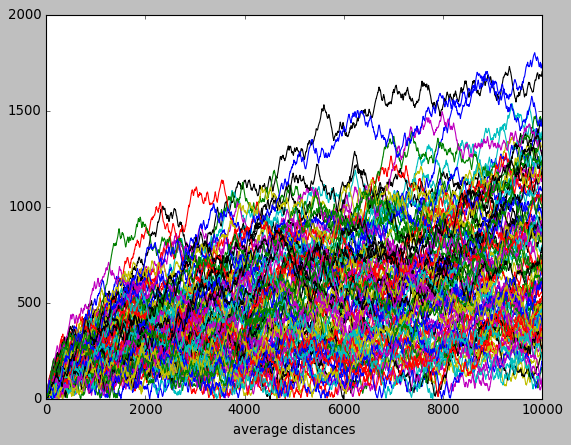

In [42]:
plt.plot(average_distances.T)
plt.xlabel('time')
plt.xlabel('average distances')
plt.show()

In [38]:
# the mean diffusion coefficient
mean_D=(y**2)/(2*n)# t=n=10,000 in our case, time is fixed in our case
print(mean_D)
print(len(D))
# so basically we have n=10,000 steps and 100 simulations. <D> is the mean diffusion coefficient after 1 step,2 steps, 3 steps, etc..


[  0.0000e+00   1.6227e-04   6.5250e-04 ...,   2.7476e+01   2.7485e+01
   2.7495e+01]
10000


In [43]:
# my code pretty much starts here
time_step=0.1
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [44]:
x_new=f(t_new)
y_new=g(t_new)

In [45]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

99989
99989
99989
99988
99988


In [46]:
# Now put them into the MCMC sampler, the second model is to be considered
import scipy.stats 
from scipy.stats import dweibull
def log_likelihood(x,a,b):# a is shape, b is scale
     return sum(dweibull.logpdf(x,scale=b,c=a))
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter

In [47]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.0004 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.4486


0.982692706523
0.983815824528


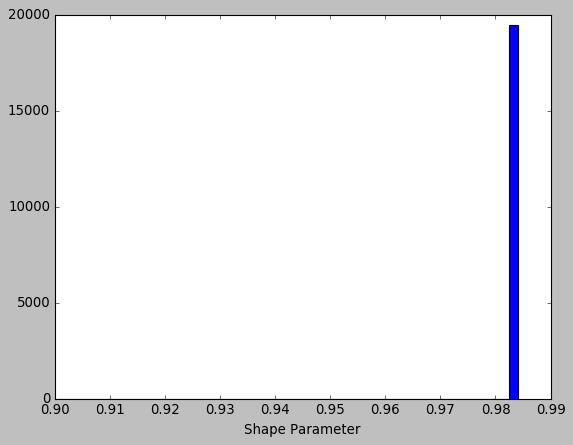

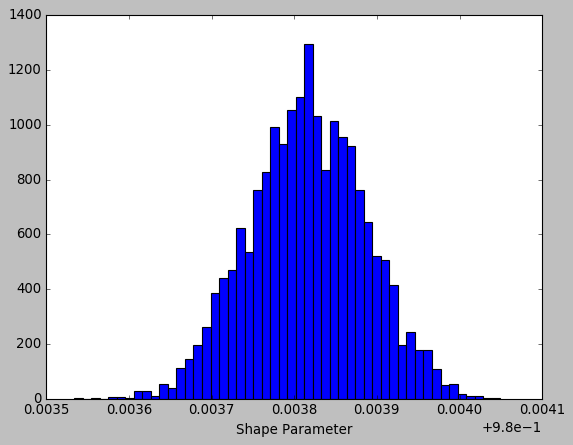

In [48]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()
B1=np.array(A1[1000:])
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()


In [49]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.0015,0.0015]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 25,000 iterations.
for p in range(25000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.4332


25001
4.40947414668
0.203030705795


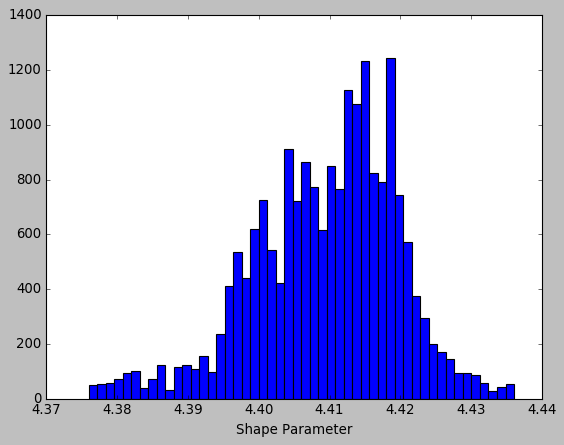

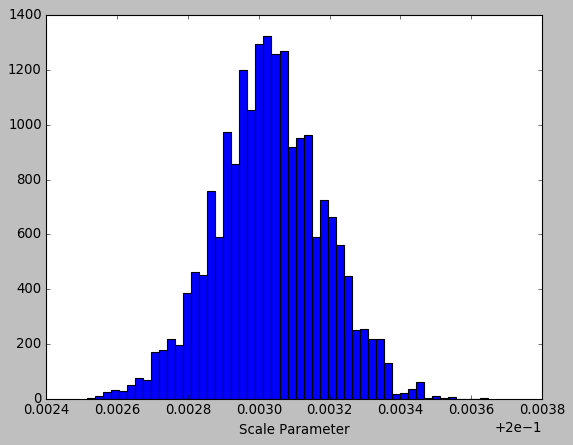

In [50]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 5000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [51]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change):# this gives samples from weibull(5,2)
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=[0]*n_change
    distance=[0]*n_change
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance[i]=(x_change[i]**2+y_change[i]**2)**0.5
    return distance 
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_mean #int(input("what's the scale?"))
beta_change=shape_mean #int(input("what's the shape?"))
c_change=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1


In [52]:
rw2_change(2)

[0, 0.2335]

In [53]:
number_of_simulations=100
average_distances_change=np.zeros((number_of_simulations,n_change))
for i in range(number_of_simulations):
    average_distances_change[i]=rw2_change(n_change)

In [54]:
print(len(t_new))
print(len(average_distances_change.mean(axis=0)))

99990
99988


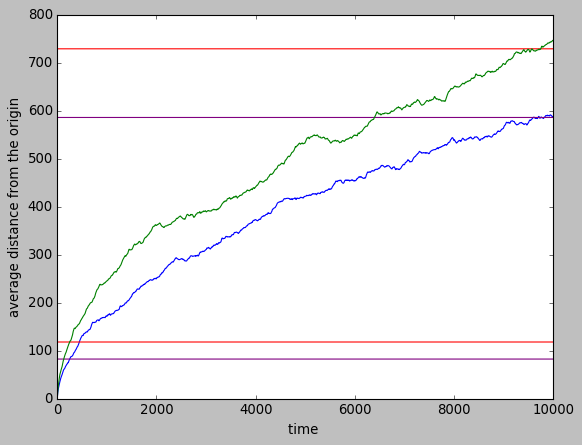

In [55]:
lower_end_vector_original=[np.percentile(average_distances.mean(axis=0),2.5)]*len(t)
upper_end_vector_original=[np.percentile(average_distances.mean(axis=0),97.5)]*len(t)
lower_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),2.5)]*len(t_new[:-2])
upper_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),97.5)]*len(t_new[:-2])
ninetyfive_percentile_original=[np.percentile(average_distances.mean(axis=0),95)]*len(t)
ninetyfive_percentile_change=[np.percentile(average_distances_change.mean(axis=0),95)]*len(t_new[:-2])
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))#important
plt.plot(t,lower_end_vector_original,color='red')
plt.plot(t,upper_end_vector_original,color='red')
plt.plot(t_new[:-2],lower_end_vector_change,color='purple')
plt.plot(t_new[:-2],upper_end_vector_change,color='purple')
#plt.plot(t_new[:-2],ninetyfive_percentile_change,color='orange')
#plt.plot(t,ninetyfive_percentile_original,color='orange')
plt.ylabel('average distance from the origin')
plt.xlabel('time ')
plt.plot(t,average_distances.mean(axis=0))#important


In [ ]:
y=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y.change=average_distances_change.mean(axis=0)
error.change=average_distances_change.var(axis=0)**0.5
plt.plot(t,y)
plt.fill_between(t, y-error, y+error,color='red')
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
plt.fill_between(t_new[:-2], y.change-error.change, y.change+error.change,color='blue')
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

In [ ]:
#the diffusion coefficient for both lines
mean_D=(y**2)/(2*len(t))
mean_D.change=(y.change**2)/(2*len(t_new))

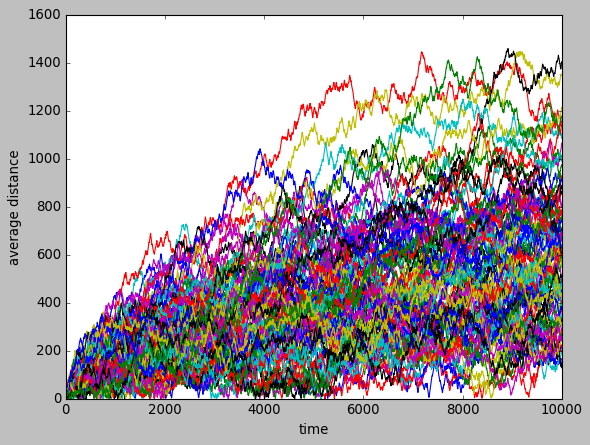

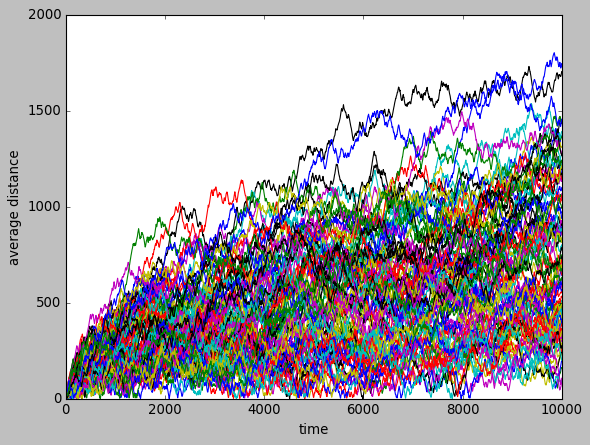

In [56]:
plt.plot(t_new[:-2],average_distances_change.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()
plt.plot(average_distances.T)
plt.xlabel('time')
plt.ylabel('average distance')
plt.show()

In [57]:
#time_step=0.2
# my code pretty much starts here
time_step=0.2
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [58]:
x_new=f(t_new)
y_new=g(t_new)

In [59]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

49994
49994
49994
49993
49993


In [60]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.0012 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.38


0.967924362864
0.968169809726


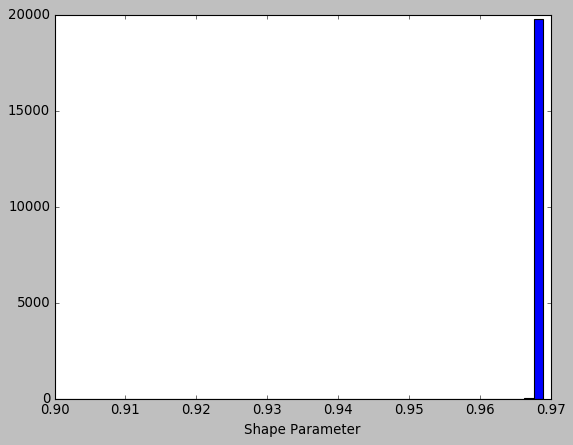

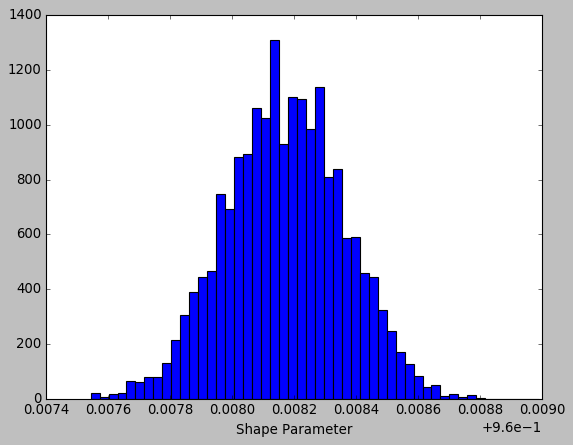

In [61]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()
B1=np.array(A1[1000:])
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()


In [62]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.0033,0.0033]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 25,000 iterations.
for p in range(25000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.4228


25001
4.43557787445
0.405858091065


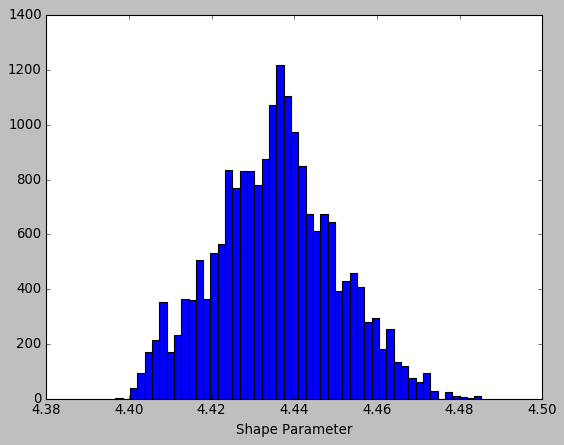

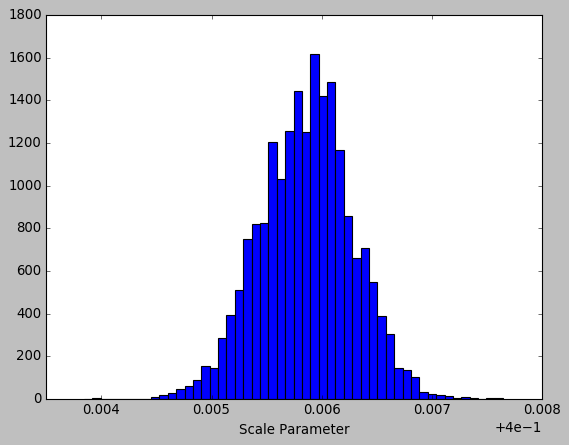

In [63]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 5000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [64]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change):# this gives samples from weibull(5,2)
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=[0]*n_change
    distance=[0]*n_change
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance[i]=(x_change[i]**2+y_change[i]**2)**0.5
    return distance 
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_mean #int(input("what's the scale?"))
beta_change=shape_mean #int(input("what's the shape?"))
c_change=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1


In [65]:
number_of_simulations=100
average_distances_change=np.zeros((number_of_simulations,n_change))
for i in range(number_of_simulations):
    average_distances_change[i]=rw2_change(n_change)

In [66]:
print(len(t_new))
print(len(average_distances_change.mean(axis=0)))

49995
49993


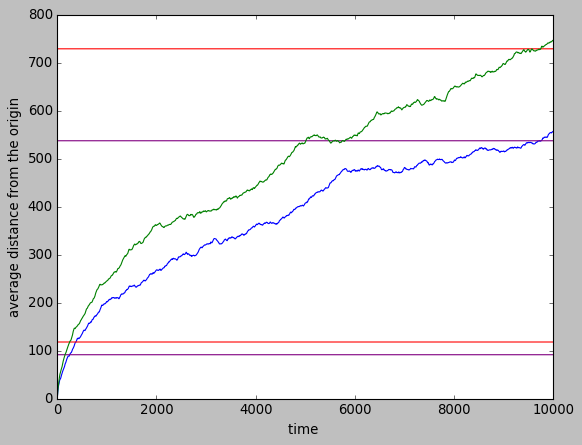

In [67]:
#plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
#plt.plot(t,average_distances.mean(axis=0))
#plt.ylabel('average distance from the origin')
#plt.xlabel('time')
#the original code
lower_end_vector_original=[np.percentile(average_distances.mean(axis=0),2.5)]*len(t)
upper_end_vector_original=[np.percentile(average_distances.mean(axis=0),97.5)]*len(t)
lower_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),2.5)]*len(t_new[:-2])
upper_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),97.5)]*len(t_new[:-2])
ninetyfive_percentile_original=[np.percentile(average_distances.mean(axis=0),95)]*len(t)
ninetyfive_percentile_change=[np.percentile(average_distances_change.mean(axis=0),95)]*len(t_new[:-2])
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))# important
plt.plot(t,lower_end_vector_original,color='red')
plt.plot(t,upper_end_vector_original,color='red')
plt.plot(t_new[:-2],lower_end_vector_change,color='purple')
plt.plot(t_new[:-2],upper_end_vector_change,color='purple')
#plt.plot(t_new[:-2],ninetyfive_percentile_change,color='orange')
#plt.plot(t,ninetyfive_percentile_original,color='orange')
plt.ylabel('average distance from the origin')
plt.xlabel('time ')
plt.plot(t,average_distances.mean(axis=0))#important

# blue is is the first one
# green is the second one

In [ ]:
y=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y.change=average_distances_change.mean(axis=0)
error.change=average_distances_change.var(axis=0)**0.5
plt.plot(t,y)
plt.fill_between(t, y-error, y+error,color='red')
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
plt.fill_between(t_new[:-2], y.change-error.change, y.change+error.change,color='blue')
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

In [ ]:
#the diffusion coefficient
mean_D=(y**2)/(2*len(t))
mean_D.change=(y.change**2)/(2*len(t_new))

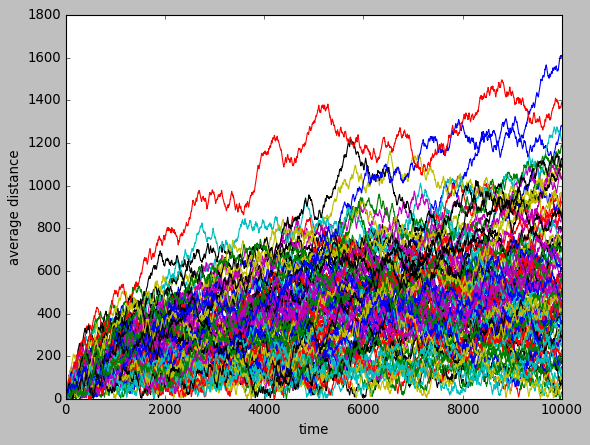

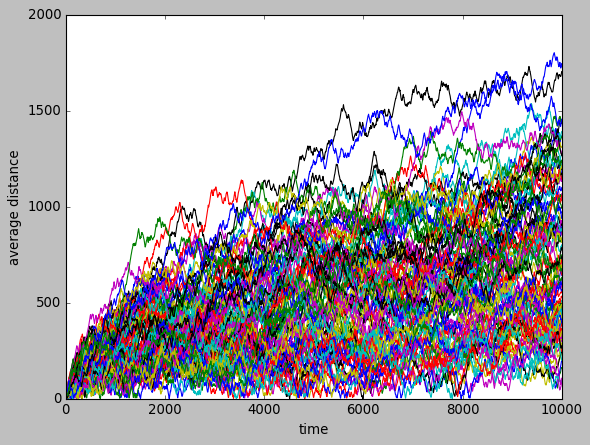

In [68]:
plt.plot(t_new[:-2],average_distances_change.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()
plt.plot(t,average_distances.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()

In [69]:
#time_step=0.3
# my code pretty much starts here
time_step=0.3
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [70]:
x_new=f(t_new)
y_new=g(t_new)

In [71]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

33329
33329
33329
33328
33328


In [72]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.002 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.4249


In [73]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.005,0.005]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3867


20001
4.46502338491
0.607997515114


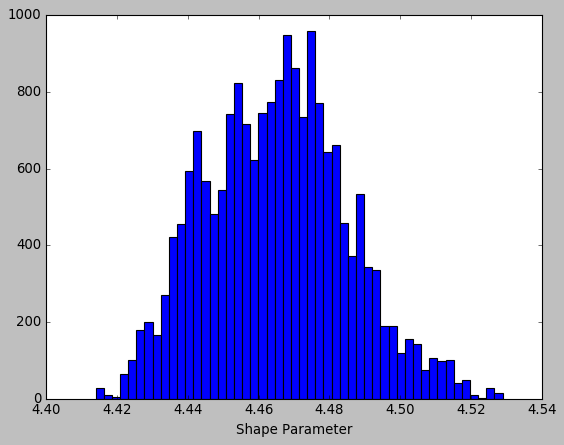

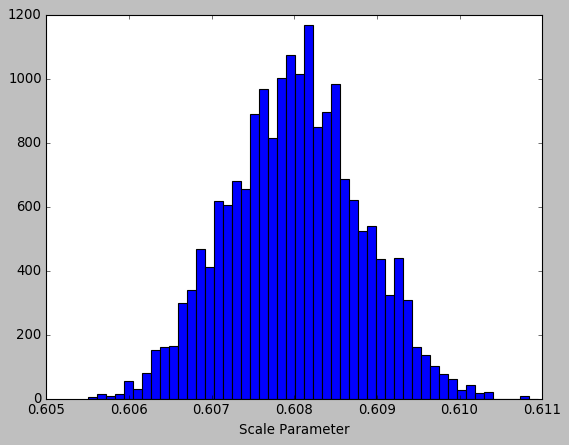

In [74]:
print(len(A2))
B2=np.array(A2[1000:])#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [75]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change):# this gives samples from weibull(5,2)
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=[0]*n_change
    distance=[0]*n_change
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance[i]=(x_change[i]**2+y_change[i]**2)**0.5
    return distance 
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_mean #int(input("what's the scale?"))
beta_change=shape_mean #int(input("what's the shape?"))
c_change=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1


In [76]:
number_of_simulations=100
average_distances_change=np.zeros((number_of_simulations,n_change))
for i in range(number_of_simulations):
    average_distances_change[i]=rw2_change(n_change)

In [77]:
print(len(t_new))
print(len(average_distances_change.mean(axis=0)))

33330
33328


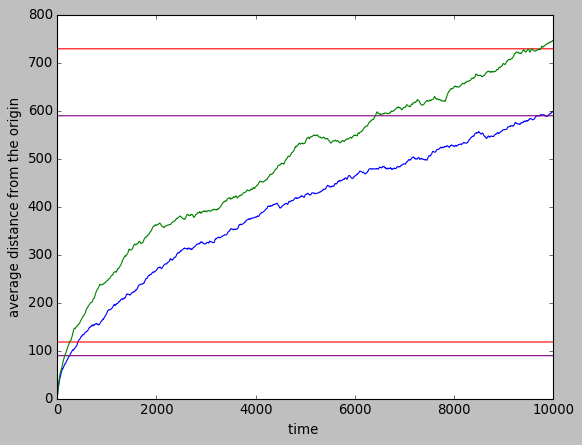

In [78]:
#plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
#plt.plot(t,average_distances.mean(axis=0))
#plt.xlabel('time')
#plt.ylabel('average distance from the origin')
lower_end_vector_original=[np.percentile(average_distances.mean(axis=0),2.5)]*len(t)
upper_end_vector_original=[np.percentile(average_distances.mean(axis=0),97.5)]*len(t)
lower_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),2.5)]*len(t_new[:-2])
upper_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),97.5)]*len(t_new[:-2])
ninetyfive_percentile_original=[np.percentile(average_distances.mean(axis=0),95)]*len(t)
ninetyfive_percentile_change=[np.percentile(average_distances_change.mean(axis=0),95)]*len(t_new[:-2])
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))#important
plt.plot(t,lower_end_vector_original,color='red')
plt.plot(t,upper_end_vector_original,color='red')
plt.plot(t_new[:-2],lower_end_vector_change,color='purple')
plt.plot(t_new[:-2],upper_end_vector_change,color='purple')
#plt.plot(t_new[:-2],ninetyfive_percentile_change,color='orange')
#plt.plot(t,ninetyfive_percentile_original,color='orange')
plt.ylabel('average distance from the origin')
plt.xlabel('time ')
plt.plot(t,average_distances.mean(axis=0))#important


In [ ]:
y=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y.change=average_distances_change.mean(axis=0)
error.change=average_distances_change.var(axis=0)**0.5
plt.plot(t,y)
plt.fill_between(t, y-error, y+error,color='red')
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
plt.fill_between(t_new[:-2], y.change-error.change, y.change+error.change,color='blue')
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

In [ ]:
mean_D=(y**2)/(2*len(t))
mean_D.change=(y.change**2)/(2*len(t_new))

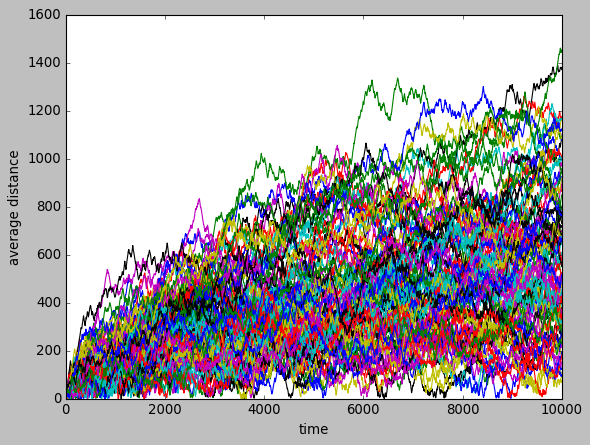

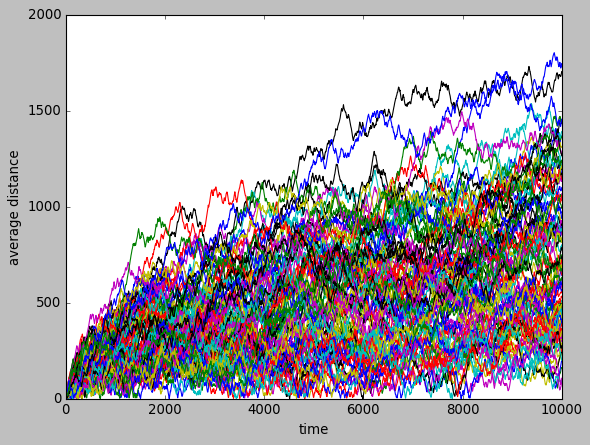

In [79]:
plt.plot(t_new[:-2],average_distances_change.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()
plt.plot(t,average_distances.T)
plt.ylabel('average distance')
plt.xlabel('time')
plt.show()

In [80]:
#time_step=2
# my code pretty much starts here
time_step=2
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [81]:
x_new=f(t_new)
y_new=g(t_new)

In [82]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

4999
4999
4999
4998
4998


In [83]:
#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.025 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.3327


In [84]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.05,0.05]  # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.394


20001
6.05425341104
3.84040718934


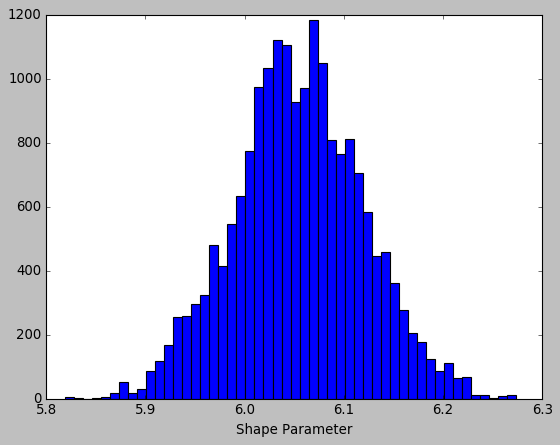

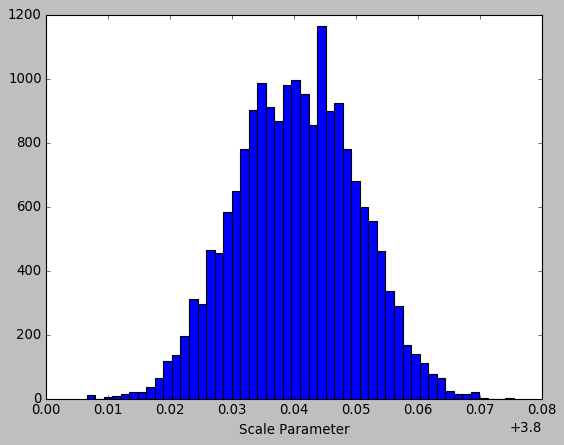

In [85]:
print(len(A2))
B2=np.array(A2[1000:])#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [86]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change):# this gives samples from weibull(5,2)
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=[0]*n_change
    distance=[0]*n_change
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance[i]=(x_change[i]**2+y_change[i]**2)**0.5
    return distance 
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_mean #int(input("what's the scale?"))
beta_change=shape_mean #int(input("what's the shape?"))
c_change=np.mean(A1)# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1


In [87]:
number_of_simulations=100
average_distances_change=np.zeros((number_of_simulations,n_change))
for i in range(number_of_simulations):
    average_distances_change[i]=rw2_change(n_change)

In [88]:
print(len(t_new))
print(len(average_distances_change.mean(axis=0)))

5000
4998


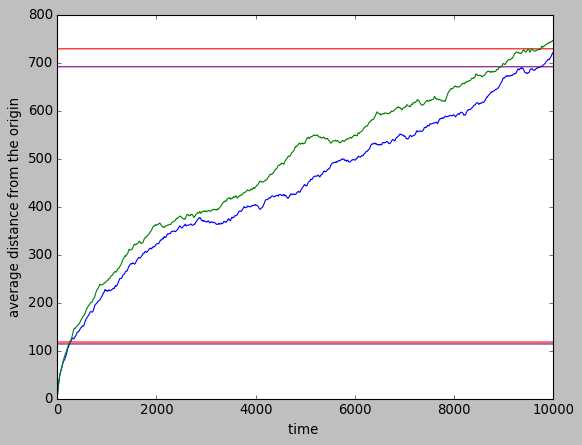

In [89]:
#plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
#plt.plot(t,average_distances.mean(axis=0))
#plt.ylabel('average distance from the origin')
#plt.xlabel('time')
lower_end_vector_original=[np.percentile(average_distances.mean(axis=0),2.5)]*len(t)
upper_end_vector_original=[np.percentile(average_distances.mean(axis=0),97.5)]*len(t)
lower_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),2.5)]*len(t_new[:-2])
upper_end_vector_change=[np.percentile(average_distances_change.mean(axis=0),97.5)]*len(t_new[:-2])
ninetyfive_percentile_original=[np.percentile(average_distances.mean(axis=0),95)]*len(t)
ninetyfive_percentile_change=[np.percentile(average_distances_change.mean(axis=0),95)]*len(t_new[:-2])
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))#important
plt.plot(t,lower_end_vector_original,color='red')
plt.plot(t,upper_end_vector_original,color='red')
plt.plot(t_new[:-2],lower_end_vector_change,color='purple')
plt.plot(t_new[:-2],upper_end_vector_change,color='purple')
#plt.plot(t_new[:-2],ninetyfive_percentile_change,color='orange')
#plt.plot(t,ninetyfive_percentile_original,color='orange')
plt.ylabel('average distance from the origin')
plt.xlabel('time ')
plt.plot(t,average_distances.mean(axis=0))#important


In [ ]:
y=average_distances.mean(axis=0)
error=average_distances.var(axis=0)**0.5
y.change=average_distances_change.mean(axis=0)
error.change=average_distances_change.var(axis=0)**0.5
plt.plot(t,y)
plt.fill_between(t, y-error, y+error,color='red')
plt.plot(t_new[:-2],average_distances_change.mean(axis=0))
plt.fill_between(t_new[:-2], y.change-error.change, y.change+error.change,color='blue')
#plt.plot(t,y-error)
#plt.plot(t,y+error)
plt.xlabel('time')
plt.ylabel('mean average distance')
plt.show()

In [ ]:
mean_D=(y**2)/(2*len(t))
mean_D.change=(y.change**2)/(2*len(t_new))

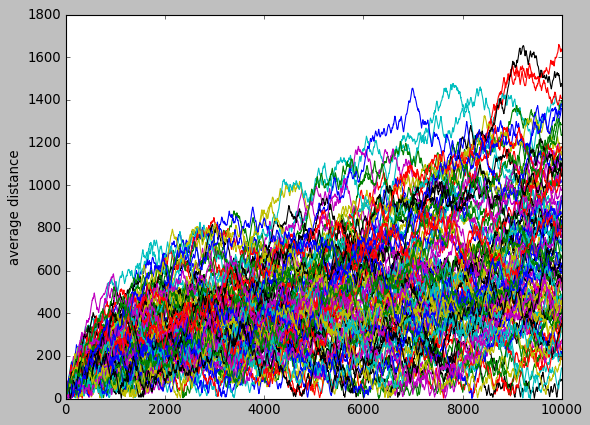

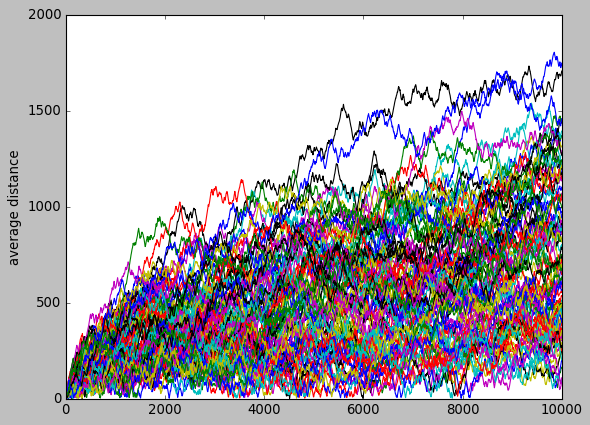

In [90]:
plt.plot(t_new[:-2],average_distances_change.T)
plt.ylabel('average distance')
plt.show()
plt.plot(t,average_distances.T)
plt.ylabel('average distance')
plt.show()

In [91]:
import numpy as np
a = [154, 400, 1124, 82, 94, 108]
print(np.percentile(a,0.025))# gives the 95th percentile
print(np.percentile(a,0.975))

82.015
82.585
